In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df1 = pd.read_csv(r"C:\Users\hp\Downloads\dataset.csv")

# Explicitly copy the desired columns using .loc
df = df1.loc[:, ['idates', 'imonths', 'iyears', 'obs','meanmod','stdmod']].copy()

# Create a datetime column from the year, month, and day information
df['datetime'] = pd.to_datetime({'year': df['iyears'], 'month': df['imonths'], 'day': df['idates']})

# Save the new DataFrame without the index
df.to_csv('new_output_file.csv', index=False)
df = df.drop(['idates', 'imonths', 'iyears'], axis=1)
df.to_csv('output_file.csv', index=False)

df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,obs,meanmod,stdmod
datetime,,,
2007-01-01,0.0,0.0,0.0
2007-01-02,0.0,0.0,0.0
2007-01-03,0.0,0.0,0.0
2007-01-04,0.0,0.0,0.0
2007-01-05,0.0,0.0,0.0


In [4]:
df1

,idates,imonths,iyears,obs,meanmod,stdmod
0,1,1,2007,0.0,0.0,0.0
1,2,1,2007,0.0,0.0,0.0
2,3,1,2007,0.0,0.0,0.0
3,4,1,2007,0.0,0.0,0.0
4,5,1,2007,0.0,0.0,0.0
...,...,...,...,...,...,...
4990,21,12,2020,0.0,0.0,0.0
4991,22,12,2020,0.0,0.0,0.0
4992,23,12,2020,0.0,0.0,0.0
4993,24,12,2020,0.0,0.0,0.0


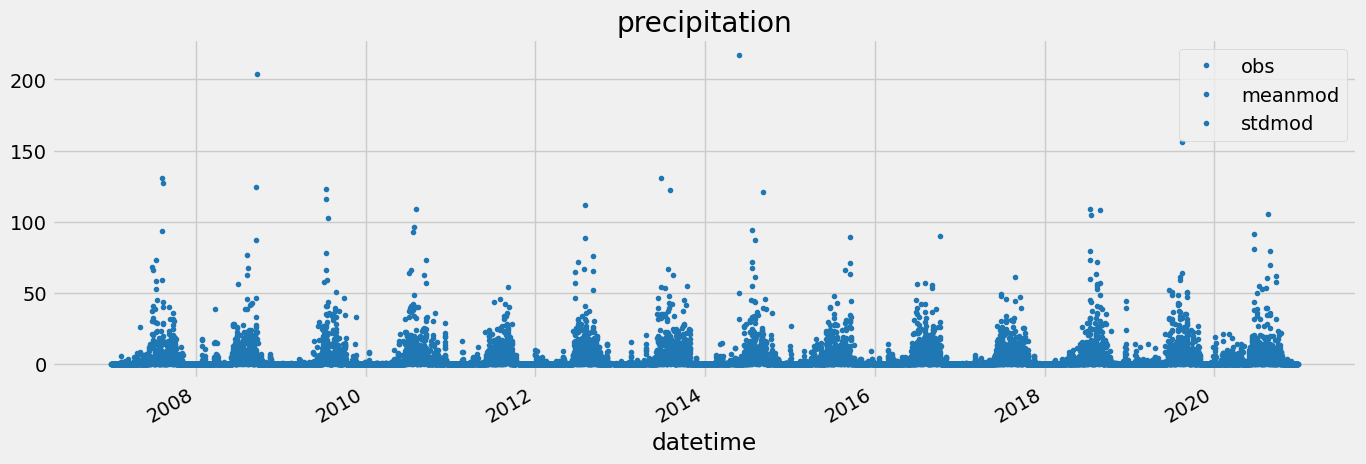

In [5]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='precipitation')
plt.show()

<AxesSubplot:ylabel='Frequency'>

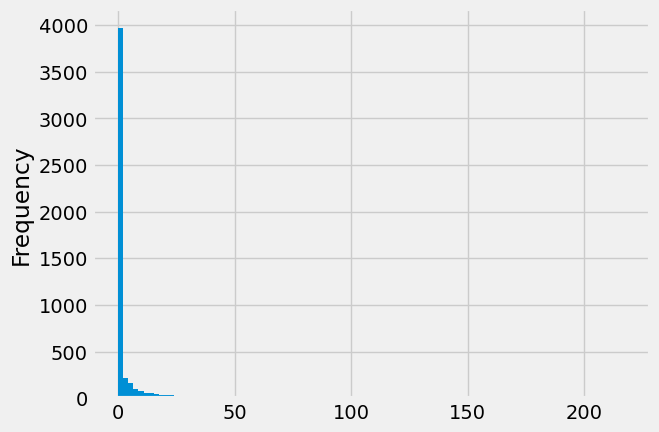

In [6]:
df['obs'].plot(kind='hist', bins=100)

In [7]:
# df.query('obs>130').plot(figsize=(15,5),style=".")

In [8]:
# df = df.query('obs<130').copy()

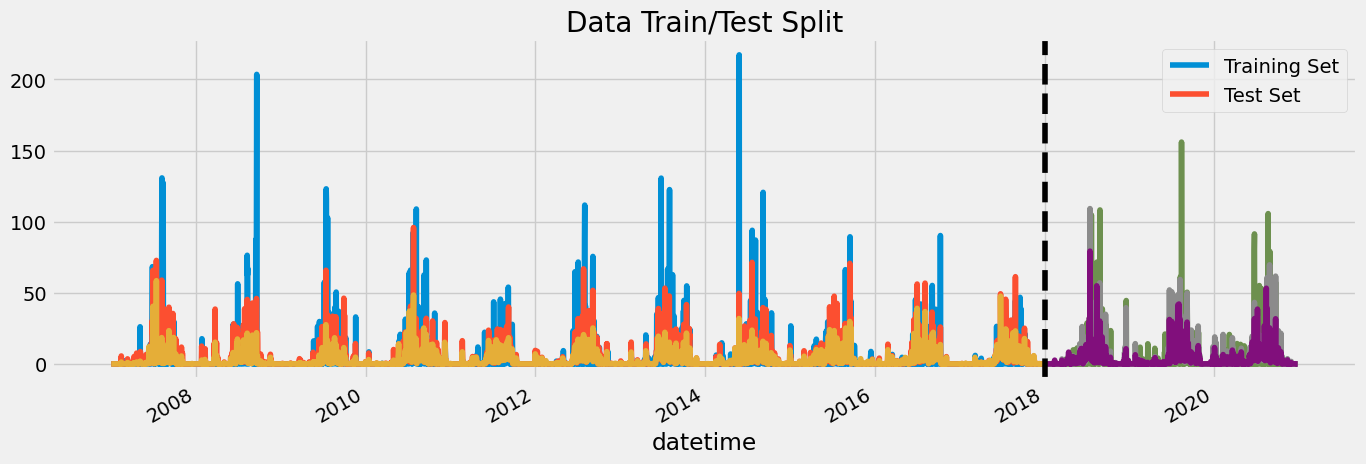

In [7]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [8]:
from sklearn.model_selection import TimeSeriesSplit
#test size 1 day*365 days*1 year
tss = TimeSeriesSplit(n_splits=5, test_size=1*365*1, gap=1)
df = df.sort_index()

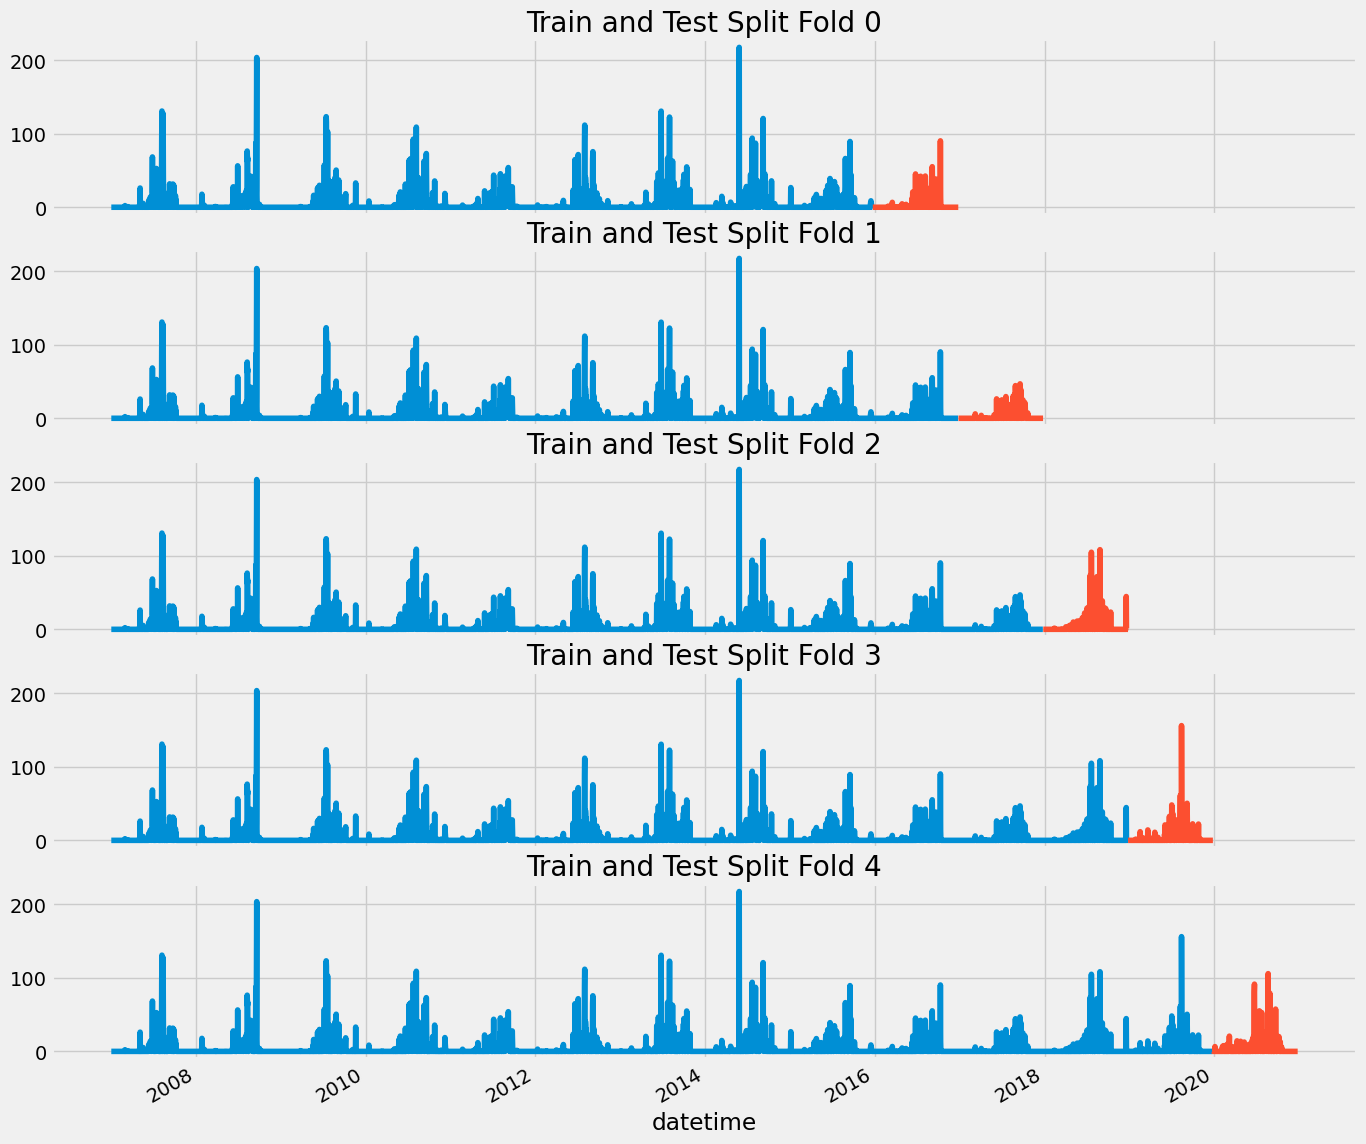

In [9]:
#time series cross validation
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['obs'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train and Test Split Fold {fold}')
    test['obs'].plot(ax=axs[fold],
                         label='Test Set')
    #axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [11]:
df1['meanmod']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4990    0.0
4991    0.0
4992    0.0
4993    0.0
4994    0.0
Name: meanmod, Length: 4995, dtype: float64

In [12]:
df['dayofmonth']

datetime
2007-01-01     1
2007-01-02     2
2007-01-03     3
2007-01-04     4
2007-01-05     5
              ..
2020-12-21    21
2020-12-22    22
2020-12-23    23
2020-12-24    24
2020-12-25    25
Name: dayofmonth, Length: 4995, dtype: int64

In [13]:
def add_lags(df):
    target_map = df['obs'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [14]:
df = add_lags(df)

In [15]:
df.head()

,obs,meanmod,stdmod,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
datetime,,,,,,,,,,,,,
2007-01-01,0.0,0.0,0.0,0,1,1,2007,1,1,1,NaN,NaN,NaN
2007-01-02,0.0,0.0,0.0,1,1,1,2007,2,2,1,NaN,NaN,NaN
2007-01-03,0.0,0.0,0.0,2,1,1,2007,3,3,1,NaN,NaN,NaN
2007-01-04,0.0,0.0,0.0,3,1,1,2007,4,4,1,NaN,NaN,NaN
2007-01-05,0.0,0.0,0.0,4,1,1,2007,5,5,1,NaN,NaN,NaN


In [16]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler  
import numpy as np
import pandas as pd

# Assume df is already loaded and sorted by date
df = df.sort_index()

# Create features function - Assuming a function that extracts time features and lag features
def create_advanced_features(data):
    data['dayofyear'] = data.index.dayofyear
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['month_year'] = data['month'] + data['year'] * 12  # Interaction term

    # Rolling window features
    data['rolling_mean_7'] = data['obs'].shift(1).rolling(window=7).mean()
    data['rolling_std_7'] = data['obs'].shift(1).rolling(window=7).std()

    # Expanded lag features to capture more temporal dynamics
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Including weekly and monthly lags
        data[f'lag{lag}'] = data['obs'].shift(lag)

    data.dropna(inplace=True)  # Ensure no NA values
    return data

df = create_advanced_features(df)


# Feature and target definition
FEATURES = [
    'dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'month_year',
    'rolling_mean_7', 'rolling_std_7', 'lag1', 'lag2', 'lag3', 'lag7', 'lag14', 'lag21', 'lag28'
]
TARGET = 'obs'
df['sin_month'] = np.sin(2 * np.pi * df['month']/12)
df['cos_month'] = np.cos(2 * np.pi * df['month']/12)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])
# TimeSeriesSplit setup
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)

# Placeholder for predictions and scores
scores = []

# Grid Search to optimize RandomForest parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Running the model training and validation within the TimeSeries split loop
for train_idx, val_idx in tss.split(df):
    X_train, X_test = df.iloc[train_idx][FEATURES], df.iloc[val_idx][FEATURES]
    y_train, y_test = df.iloc[train_idx][TARGET], df.iloc[val_idx][TARGET]
    
    # Handling missing, infinite values, and ensuring all data is float
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train.fillna(method='ffill', inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.fillna(method='ffill', inplace=True)

    # Random Forest model with grid search
    best_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=0)
    best_model.fit(X_train, y_train)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predictions and scoring
    y_pred = best_model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

# Print the best score and parameters
print("Best RMSE per fold:", scores)
print("Average RMSE:", np.mean(scores))
print("Best parameters:", grid_search.best_params_)




KeyError: "['stdmodrolling_mean_7'] not in index"

In [ ]:
# # Check for NaNs or infinite values after preprocessing
# print("NaNs in X_train:", X_train.isna().sum().sum())
# print("NaNs in y_train:", y_train.isna().sum())
# print("NaNs in X_test:", X_test.isna().sum().sum())
# print("NaNs in y_test:", y_test.isna().sum())

# print("Infinite values in X_train:", np.isinf(X_train).sum().sum())
# print("Infinite values in y_train:", np.isinf(y_train).sum())
# print("Infinite values in X_test:", np.isinf(X_test).sum().sum())
# print("Infinite values in y_test:", np.isinf(y_test).sum())



In [35]:
scores

[8.960475397162346,
 6.547689154337872,
 11.170913547042684,
 10.32179494250896,
 11.005371262967984]

In [36]:
print(f'mean square error across folds {np.mean(scores):0.4f}')
print(f'Fold mean square error:{scores}')

mean square error across folds 9.6012
Fold mean square error:[8.960475397162346, 6.547689154337872, 11.170913547042684, 10.32179494250896, 11.005371262967984]


In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
def create_advanced_features(data):
    data['dayofyear'] = data.index.dayofyear
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['month_year'] = data['month'] + data['year'] * 12  # Interaction term

    # Rolling window features
    data['rolling_mean_7'] = data['obs'].shift(1).rolling(window=7).mean()
    data['rolling_std_7'] = data['obs'].shift(1).rolling(window=7).std()

    # Expanded lag features to capture more temporal dynamics
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Including weekly and monthly lags
        data[f'lag{lag}'] = data['obs'].shift(lag)

    data.dropna(inplace=True)  # Ensure no NA values
    return data

df = create_advanced_features(df)

FEATURES = [
    'dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'month_year',
    'rolling_mean_7', 'rolling_std_7', 'lag1', 'lag2', 'lag3', 'lag7', 'lag14', 'lag21', 'lag28'
]
TARGET = 'obs'


# Example of adding cyclic features
df['sin_month'] = np.sin(2 * np.pi * df['month']/12)
df['cos_month'] = np.cos(2 * np.pi * df['month']/12)

# Scaling features
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])
X_all = df[FEATURES]
y_all = df[TARGET]
# Re-running the model with simplified parameters
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=0)
model.fit(X_all, y_all)
y_pred_all = model.predict(X_all)
rmse = np.sqrt(mean_squared_error(y_all, y_pred_all))
print(f"RMSE: {rmse}")


RMSE: 7.301418214082984


In [27]:
df.index.max()

Timestamp('2020-12-25 00:00:00')

In [28]:
df


,obs,meanmod,stdmod,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,lag3,month_year,rolling_mean_7,rolling_std_7,lag7,lag14,lag21,lag28,sin_month,cos_month
datetime,,,,,,,,,,,,,,,,,,,,,
2007-04-23,0.0,0.07,0.08,-1.500603,-0.475678,-0.756002,-1.678399,-0.689092,23,17,...,-0.305123,-1.733977,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,8.660254e-01,-0.5
2007-04-24,0.0,0.03,0.05,-1.000231,-0.475678,-0.756002,-1.678399,-0.679508,24,17,...,-0.305123,-1.733977,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,8.660254e-01,-0.5
2007-04-25,0.0,0.00,0.00,-0.499859,-0.475678,-0.756002,-1.678399,-0.669924,25,17,...,-0.305123,-1.733977,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,8.660254e-01,-0.5
2007-04-26,0.0,0.16,0.09,0.000512,-0.475678,-0.756002,-1.678399,-0.660339,26,17,...,-0.305123,-1.733977,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,8.660254e-01,-0.5
2007-04-27,0.0,0.37,0.18,0.500884,-0.475678,-0.756002,-1.678399,-0.650755,27,17,...,-0.305123,-1.733977,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,8.660254e-01,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-21,0.0,0.00,0.00,-1.500603,1.330494,1.588030,1.592704,1.639879,21,52,...,-0.305123,1.707803,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,-2.449294e-16,1.0
2020-12-22,0.0,0.00,0.00,-1.000231,1.330494,1.588030,1.592704,1.649464,22,52,...,-0.305123,1.707803,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,-2.449294e-16,1.0
2020-12-23,0.0,0.00,0.00,-0.499859,1.330494,1.588030,1.592704,1.659048,23,52,...,-0.305123,1.707803,-0.530216,-0.539888,-0.305123,-0.305123,-0.305123,-0.305123,-2.449294e-16,1.0


In [29]:
# Add predicted values as a new column to the DataFrame
df['predicted_data'] = y_pred_all

In [30]:
# Replace negative predicted values with zero
df['predicted_data'] =df['predicted_data'].clip(lower=0)
df['predicted_data'] = df['predicted_data'].clip(lower=0).round(2)

In [31]:
from sklearn.metrics import r2_score

# Calculate bias
bias = np.mean(y_pred_all - y_all)

# Calculate standard deviation
std = np.std(y_pred_all - y_all)

# Calculate mean
mean = np.mean(y_pred_all)

# Calculate R-squared
r2 = r2_score(y_all, y_pred_all)

print("Bias:", bias)
print("Standard Deviation:", std)
print("Mean:", mean)
print("R-squared:", r2)


Bias: 0.0483785027804499
Standard Deviation: 7.1894796597543635
Mean: 3.818427652893086
R-squared: 0.6614120277261617


In [32]:
from sklearn.metrics import mean_squared_error, r2_score

rmse_meanmod = np.sqrt(mean_squared_error(df['obs'], df['meanmod']))
r2_meanmod = r2_score(df['obs'], df['meanmod'])
bias_meanmod = np.mean(df['meanmod'] - df['obs'])
mean_meanmod = np.mean(df['meanmod'])

print("RMSE for meanmod:", rmse_meanmod)
print("R-squared for meanmod:", r2_meanmod)
print("Bias for meanmod:", bias_meanmod)
print("Mean for meanmod:", mean_meanmod)

mean_obs=np.mean(df['obs'])
print('obs mean',mean_obs)


RMSE for meanmod: 10.838925776124677
R-squared for meanmod: 0.23046313838351928
Bias for meanmod: 0.5607290600040966
Mean for meanmod: 4.33077821011675
obs mean 3.770049150112638


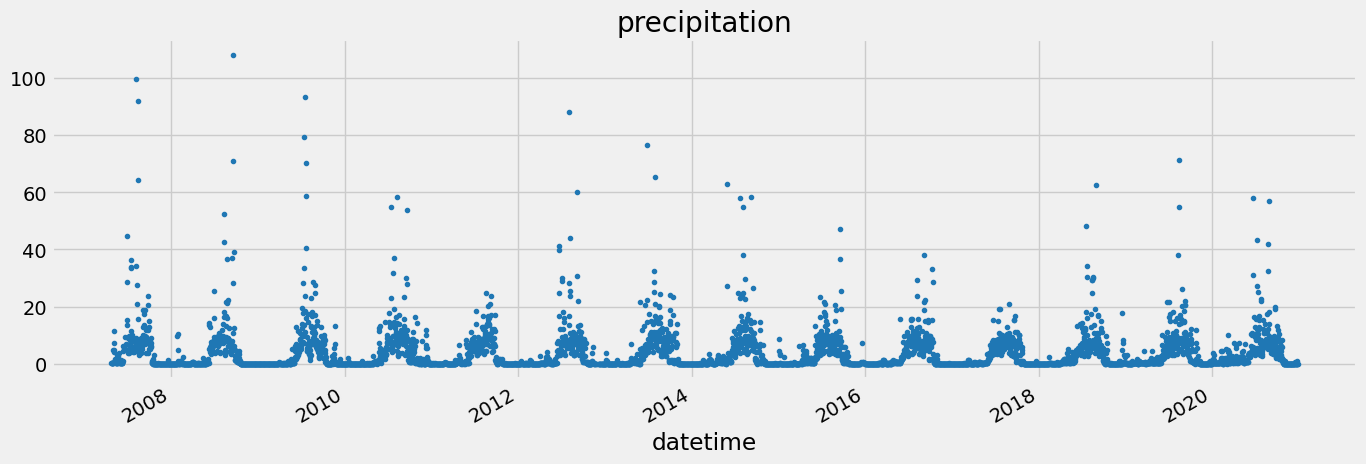

In [33]:
df['predicted_data'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='precipitation')
plt.show()